# Test_02
---

## Description of Test_02

Test_02에서는 Word Embedding을 통해,

사람이 직접 설계한 데이터 특성이 아닌, 

데이터의 벡터화를 통해 컴퓨터가 스스로 학습했을 경우의 결과를 파악하기 위한 실험진행

---

## 실험 목차

    1. 다양한 파라미터 조정을 통해 가장 바람직해 보이는 Word2Vec 모델 생성
    2. 모델의 시각화
    3. 모델을 바탕으로 분류모델에 적용 및 결과확인
---

### | Package Import

In [1]:
import pandas as pd
import numpy as np
import warnings
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

### | Data Load

In [2]:
d_path = 'jigsaw-toxic-comment-classification-challenge'
original_df = pd.read_csv(d_path + '/train.csv')

# 텍스트 Feature만을 담고 있는 df texts 정의
texts = original_df['comment_text'].to_frame()

# Label 전체의 정보를 담고 있는 df vicious 정의
vicious = original_df.iloc[:, 2:]

# 악의성 여부만을 담고 있는 df label 정의
label = original_df.iloc[:, 2:].sum(axis=1).map(lambda x : 1 if x > 0 else 0).to_frame().rename(columns={0 : 'label'})

### | Text Tokenize

Tokenize 함수를 사용해서

기본 텍스트를 Tokenize, Lemmatize, Remove StopWords가 적용된 df를 반환한다 

In [3]:
from d_pre import tokenize

token_words = tokenize(texts)

In [4]:
token_df = pd.concat([token_words, label], axis=1)

In [5]:
display(token_df.head())

,comment_text,label
0,"[explanation, edits, made, username, hardcore,...",0
1,"[aww, match, background, colour, seemingly, st...",0
2,"[hey, man, really, trying, edit, war, guy, con...",0
3,"[make, real, suggestion, improvement, wondered...",0
4,"[sir, hero, chance, remember, page]",0


### | Train Validation Test Dataset Split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(token_df['comment_text'], 
                                                    token_df['label'], 
                                                    test_size=1-train_ratio, 
                                                    stratify=token_df['label'], 
                                                    random_state=42)

# Validation Test Split
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=test_ratio / (test_ratio + val_ratio), 
                                                stratify=y_test, 
                                                random_state=42)

### | Word2Vec Model 생성

In [7]:
from gensim.models import Word2Vec

num_features = 500

emb_model = Word2Vec(X_train, 
                     size=num_features, 
                     iter=100, 
                     window=10, 
                     min_count=500, 
                     seed=42,
                     sample=1e-3, 
                     workers=-1, 
                     sg=1)

emb_model.init_sims(replace=True)

<b>Word2Vec Model의 성능을 측정하기 위한 방법으로 단어들 중 거리가 먼 단어를 판별하는 doesnt_match 함수와 특정단어와 거리가 가까운 단어의 리스트를 반환하는 most_similar 함수를 사용해서 파악한다.</b>

In [8]:
emb_model.wv.doesnt_match('man woman child'.split())

'woman'

In [11]:
emb_model.most_similar('english')

[('anywhere', 0.17910385131835938),
 ('wow', 0.14714360237121582),
 ('lot', 0.12826314568519592),
 ('experiment', 0.12339150905609131),
 ('attitude', 0.12088607251644135),
 ('ancient', 0.11668157577514648),
 ('common', 0.11462736129760742),
 ('beginning', 0.11343918740749359),
 ('doubt', 0.11222444474697113),
 ('primary', 0.11160566657781601)]

In [26]:
word_vectors = emb_model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

### | Bag of Words

In [27]:
vocabs

dict_keys(['island', 'wondering', 'page', 'way', 'explain', 'change', 'also', 'talk', 'think', 'lot', 'information', 'make', 'list', 'le', 'mean', 'thanks', 'utc', 'add', 'complaint', 'however', 'please', 'read', 'editor', 'want', 'personal', 'attack', 'situation', 'reviewed', 'first', 'thank', 'c', 'user', 'editing', 'ip', 'related', 'note', 'try', 'keep', 'eye', 'feel', 'free', 'let', 'know', 'problem', 'regard', 'edit', 'conflict', 'ok', 'protected', 'account', 'deal', 'good', 'part', 'old', 'three', 'day', 'added', 'tag', 'remove', 'protection', 'use', 'wp', 'cheer', 'much', 'hope', 'help', 'suggest', 'high', 'school', 'separate', 'enough', 'threat', 'mr', 'sort', 'article', 'long', 'dog', 'getting', 'assume', 'longer', 'year', 'perhaps', 'discussing', 'important', 'section', 'summary', 'create', 'topic', 'people', 'march', 'stop', 'continue', 'blocked', 'text', 'hey', 'lie', 'june', 'would', 'mind', 'telling', 'data', 'see', 'explanation', 'http', 'en', 'wikipedia', 'org', 'w', 'i

### | wv model 시각화

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca = pca.fit_transform(word_vectors_list)
pca_xs = pca[:,0]
pca_ys = pca[:,1]

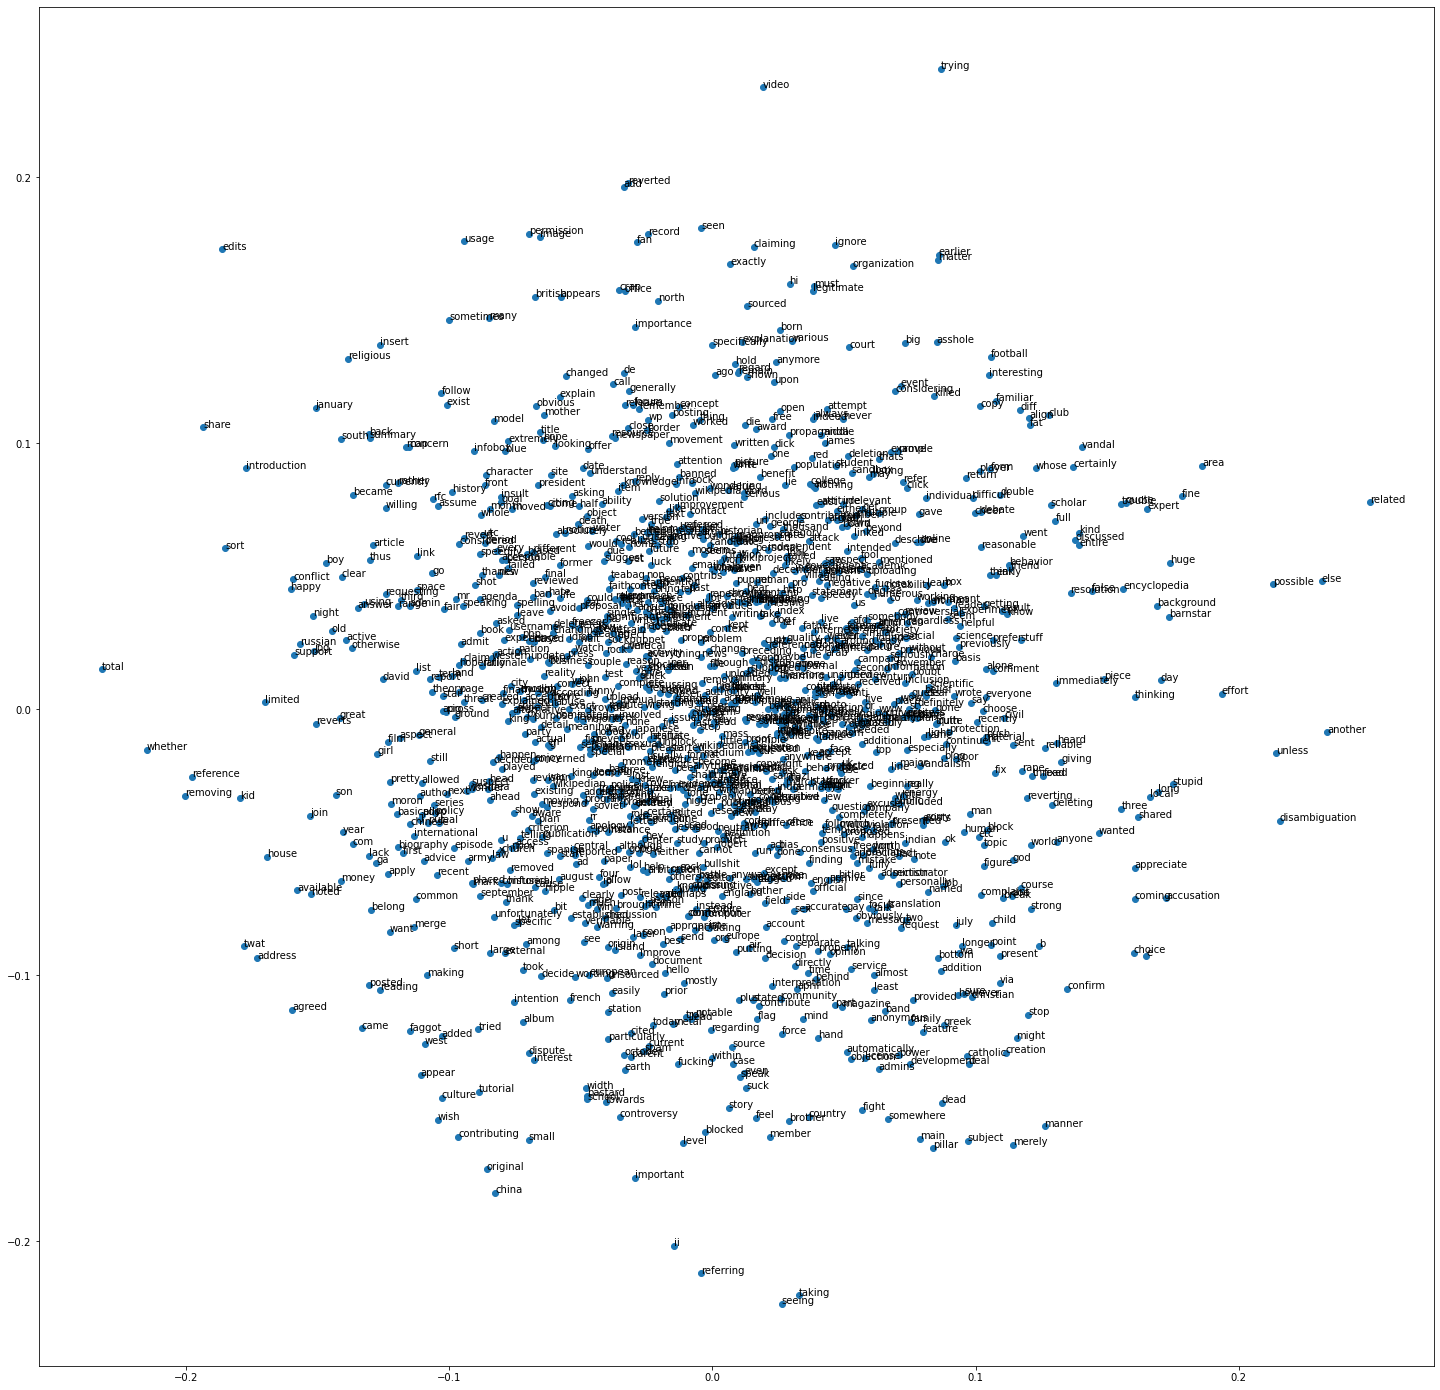

In [32]:
plt.figure(figsize=(25, 25))

plt.scatter(pca_xs, pca_ys)

for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(pca_xs[i], pca_ys[i]))
    
plt.show();

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=42)
tsne = tsne.fit_transform(word_vectors_list)

tsne_xs = tsne[:,0]
tsne_ys = tsne[:,1]

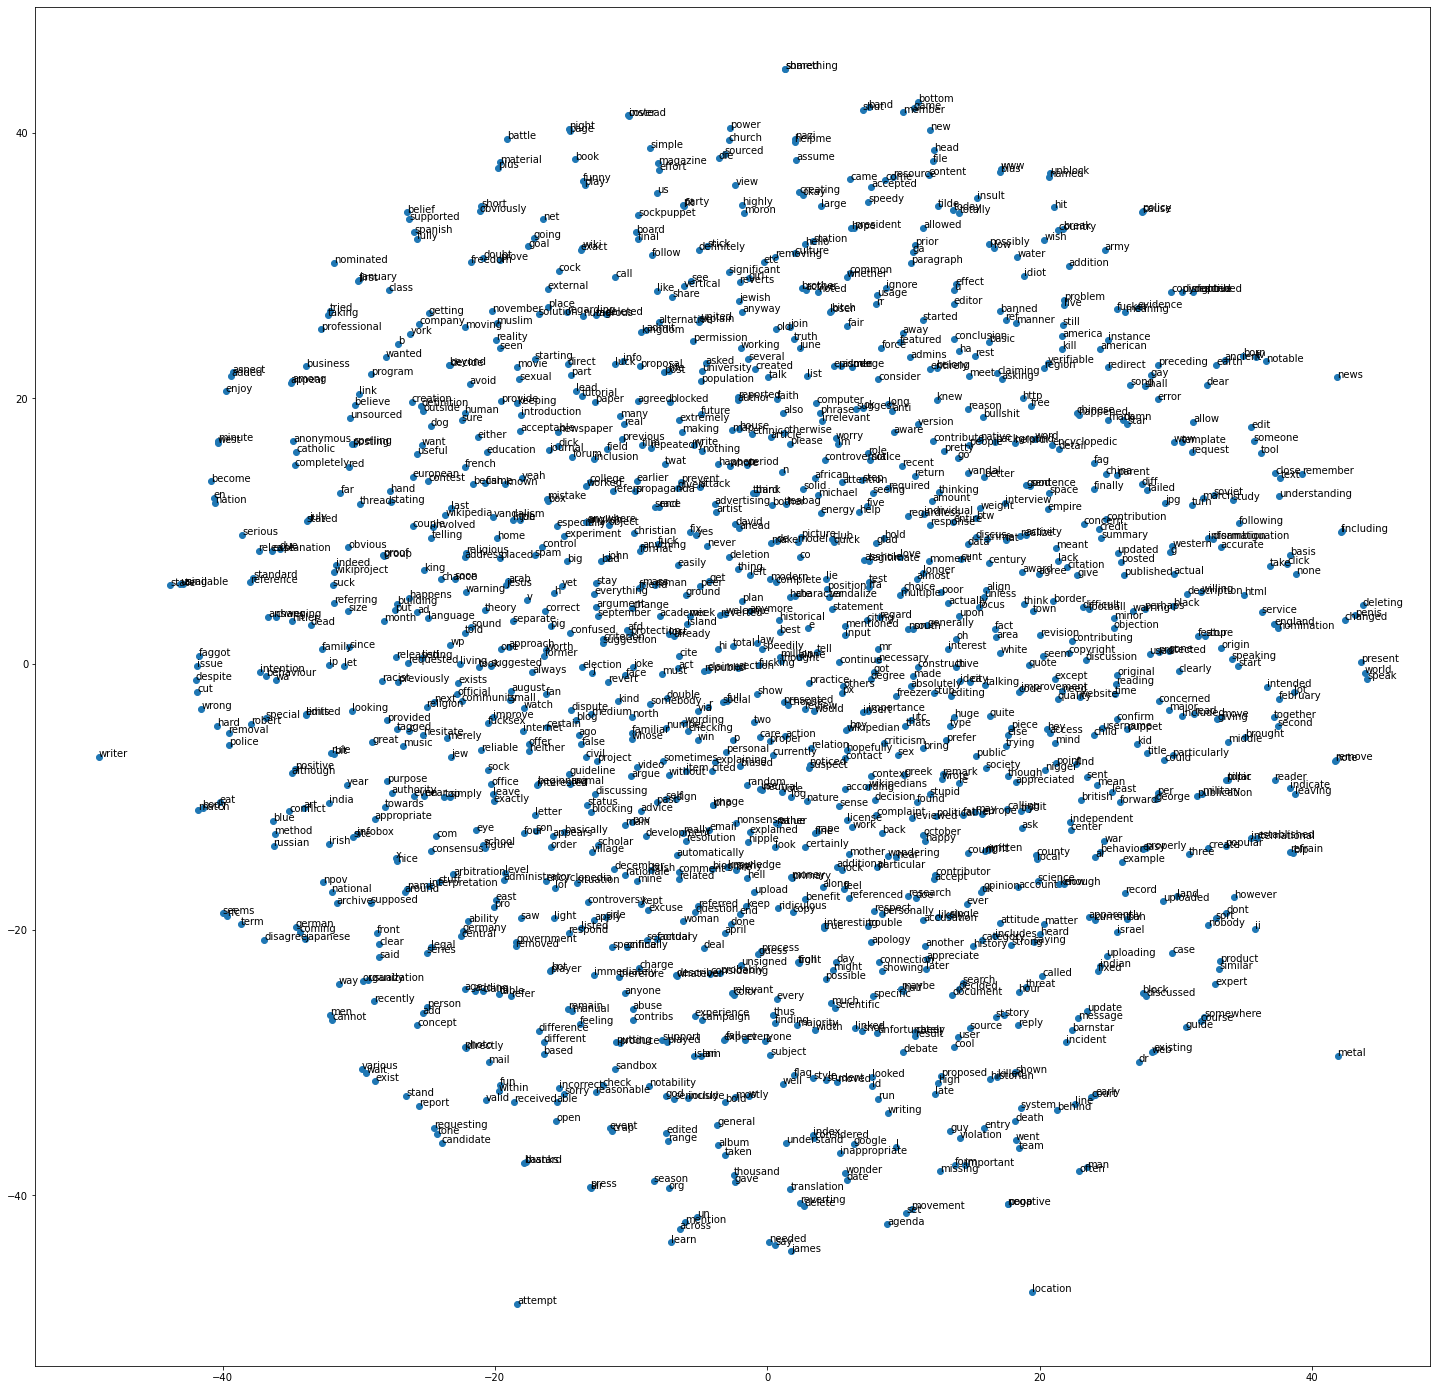

In [35]:
plt.figure(figsize=(25, 25))

plt.scatter(tsne_xs, tsne_ys)

for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(tsne_xs[i], tsne_ys[i]))
    
plt.show();

<b>tsne를 사용했을때 데이터가 더 잘 퍼져있는 것을 볼 수 있다.</b>

### | Word Vector를 만들기 위한 함수 정의

In [13]:
def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화 한다.
    featureVec = np.zeros((num_features,), dtype="float32")

    nwords = 0.
    
    # Index2word는 모델의 사전에 있는 단어명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화 한다.
    index2word_set = set(model.wv.index2word)
    
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
    
    # 결과를 단어수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec, nwords)
    
    
    return np.nan_to_num(featureVec)

In [14]:
def getAvgFeatureVecs(comments, model, num_features):
    # 텍스트 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환
    
    # 속도를 위해 2D 넘파이 배열을 미리 할당
    commentsFeatureVecs = np.zeros((len(comments), num_features), dtype="float32")
    
    for idx, comment in enumerate(comments):
        commentsFeatureVecs[int(idx)] = makeFeatureVec(comment, model, num_features)
    
    return commentsFeatureVecs

### | WordVector 데이터 생성

In [15]:
wv_train = getAvgFeatureVecs(X_train, emb_model, num_features)
wv_val = getAvgFeatureVecs(X_val, emb_model, num_features)
wv_test = getAvgFeatureVecs(X_test, emb_model, num_features)

### | Model 정의

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

lr_clf = LogisticRegression(n_jobs=-1, random_state=42)
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
rf_clf = RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state=42)
xgb_clf = XGBClassifier(random_state=42)

### | Model Fitting

In [17]:
lr_clf.fit(wv_train, y_train)
dt_clf.fit(wv_train, y_train)
rf_clf.fit(wv_train, y_train)
xgb_clf.fit(wv_train, y_train)

[14:31:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### | Validation에 대한 예측값 생성

In [18]:
std_pred = np.zeros_like(y_val.values) # 기준모델
lr_pred = lr_clf.predict(wv_val)
dt_pred = dt_clf.predict(wv_val)
rf_pred = rf_clf.predict(wv_val)
xgb_pred = xgb_clf.predict(wv_val)

### | Validation set에 대한 F1_score 측정

In [19]:
predictions = [std_pred, lr_pred, dt_pred, rf_pred, xgb_pred]
predic_names = ['std_pred', 'lr_pred', 'dt_pred', 'rf_pred', 'xgb_pred']

for pred, name in zip(predictions, predic_names):
    print('{}\'s f1_score : {}'.format(name, f1_score(y_val, pred, average='micro')))

std_pred's f1_score : 0.8983121657754011
lr_pred's f1_score : 0.9263452540106952
dt_pred's f1_score : 0.8595003342245989
rf_pred's f1_score : 0.9125167112299465
xgb_pred's f1_score : 0.9324030748663101


<b>성능이 가장 뛰어난 xgboost 모델을 바탕으로 test 예측수행</b>

In [22]:
xgb_clf.fit(wv_train, y_train)

[15:22:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
xgb_pred = xgb_clf.predict(wv_test)

<b>위의 validation set에서와 유사한 성능을 보인다</b>

In [25]:
f1_score(y_test, xgb_pred, average='micro')

0.9321941844919787